In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/community-event-drug-recovery/sample_submission.csv
/kaggle/input/community-event-drug-recovery/drug_recovery.csv


In [2]:
import missingno as msn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

In [3]:
df_raw = pd.read_csv('/kaggle/input/community-event-drug-recovery/drug_recovery.csv')
df_raw.head()

,city,gender,age,bmi,sleep,days
0,mumbai,Male,60.0,20.18,6.74,15.52
1,mumbai,Female,51.0,20.25,9.00,18.19
2,Bangalore,Female,25.0,20.57,8.47,16.32
3,Mumbai,Female,33.0,20.25,8.43,16.70
4,mumbai,Male,67.0,20.63,8.23,16.77


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    10000 non-null  object 
 1   gender  10000 non-null  object 
 2   age     9908 non-null   float64
 3   bmi     10000 non-null  float64
 4   sleep   10000 non-null  float64
 5   days    10000 non-null  float64
dtypes: float64(4), object(2)
memory usage: 468.9+ KB


So, there are 10000 entries.

> ### `Central Tendency`

In [5]:
df_raw.describe()

,age,bmi,sleep,days
count,9908.000000,10000.000000,10000.000000,10000.000000
mean,50.562071,21.676711,6.999622,15.770061
std,44.020977,1.866919,1.173446,2.579236
min,18.000000,18.500000,5.000000,10.020000
25%,32.000000,20.050000,5.970000,13.920000
50%,47.000000,21.670000,6.980000,15.550000
75%,61.000000,23.280000,8.030000,17.490000
max,550.000000,24.900000,9.000000,23.990000


In [6]:
df_raw.describe(include = 'object')

,city,gender
count,10000,10000
unique,4,4
top,Mumbai,Male
freq,4026,3998


In [7]:
df = df_raw.copy()

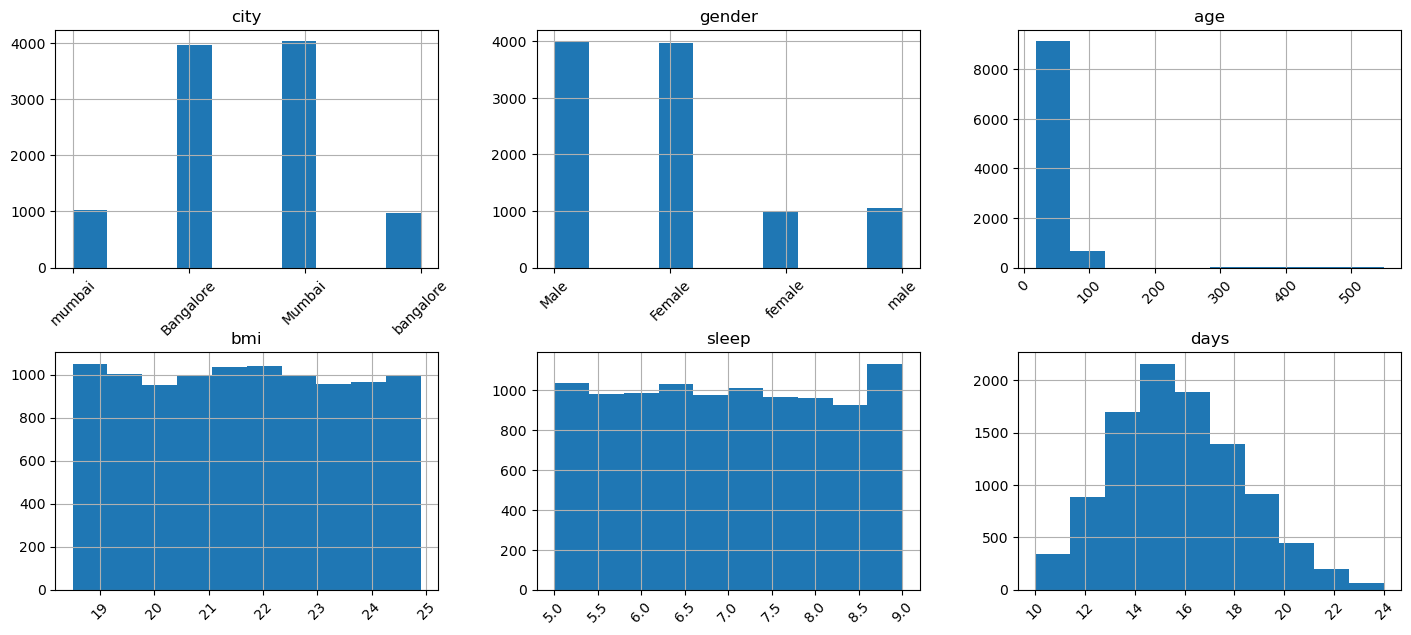

In [8]:
fig, ax = plt.subplots(2,3, figsize=(15,7))
fig.tight_layout(pad=4)
for i,item in enumerate(df.columns):
    plt.subplot(2,3,i+1)
    df[item].hist()
    plt.xticks(rotation=45)
    plt.title(item)
    
plt.show()

> ### `Column Manipulations`

In [9]:
df['city'].replace({'mumbai' : 'Mumbai'}, inplace=True)
df['city'].replace({'bangalore':'Bangalore'}, inplace=True)
df['gender'].replace({'female':'Female'}, inplace=True)
df['gender'].replace({'male':'Male'}, inplace=True)

In [10]:
df['city'].value_counts(normalize=True)

Mumbai       0.5054
Bangalore    0.4946
Name: city, dtype: float64

In [11]:
df['gender'].value_counts(normalize=True)

Male      0.5049
Female    0.4951
Name: gender, dtype: float64

From the histogram plot, we can see that, only, age column has few numbers of outliers.

In [12]:
len(df[df['age']>100]['age'])

111

In [13]:
idx = df[df['age']>100].index
df.drop(index=idx, inplace=True)

<AxesSubplot:>

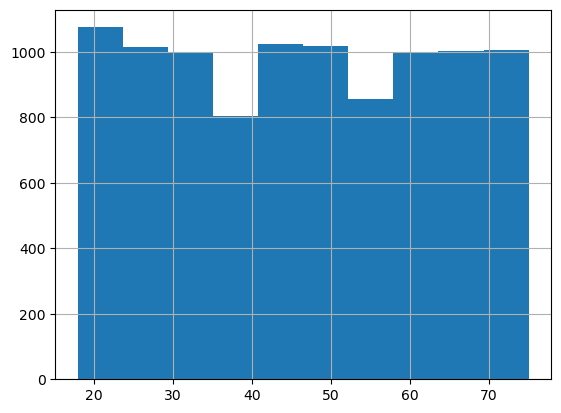

In [14]:
df['age'].hist()

> ### `Missing Values`

<AxesSubplot:>

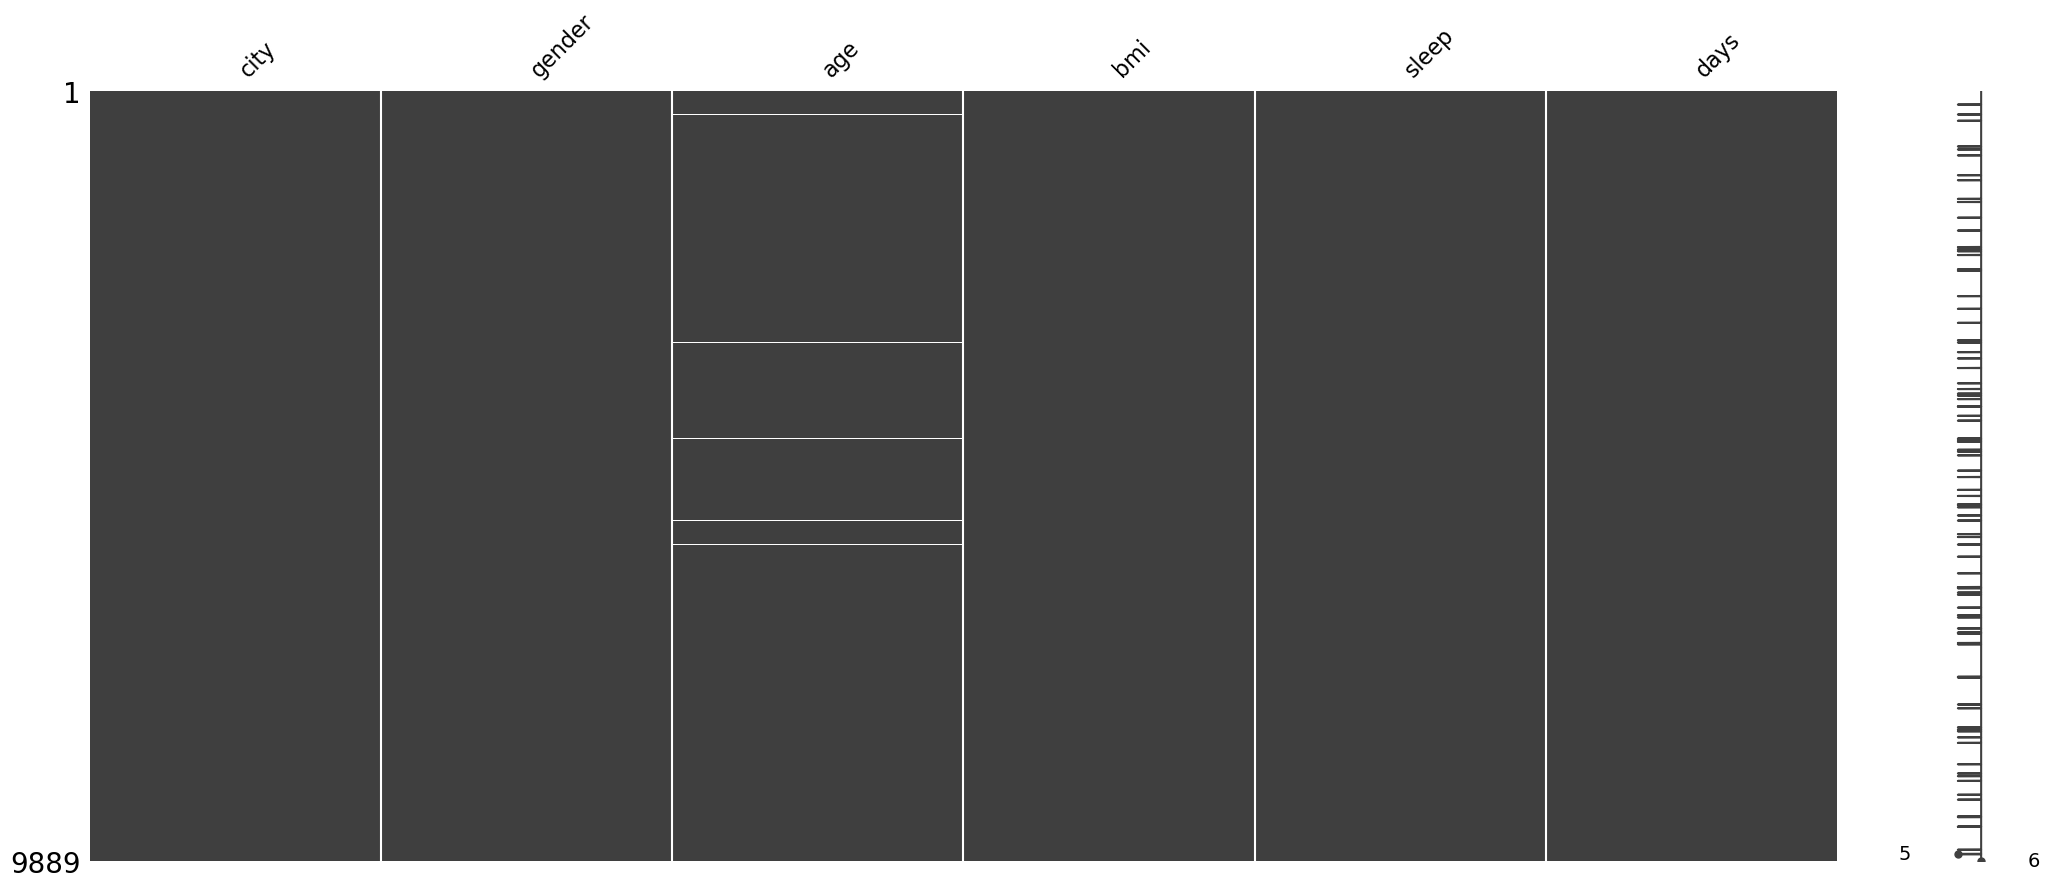

In [15]:
msn.matrix(df)

In [16]:
df.isnull().mean().sort_values(ascending = False)

age       0.009303
city      0.000000
gender    0.000000
bmi       0.000000
sleep     0.000000
days      0.000000
dtype: float64

In [17]:
imputer = KNNImputer(n_neighbors = 5)
df['age'] = imputer.fit_transform(np.array(df['age']).reshape(-1,1))

> ### `Correlations` 

### **Numeric Columns**
First, lets try to understand the pearson correlation with the numeric columns.

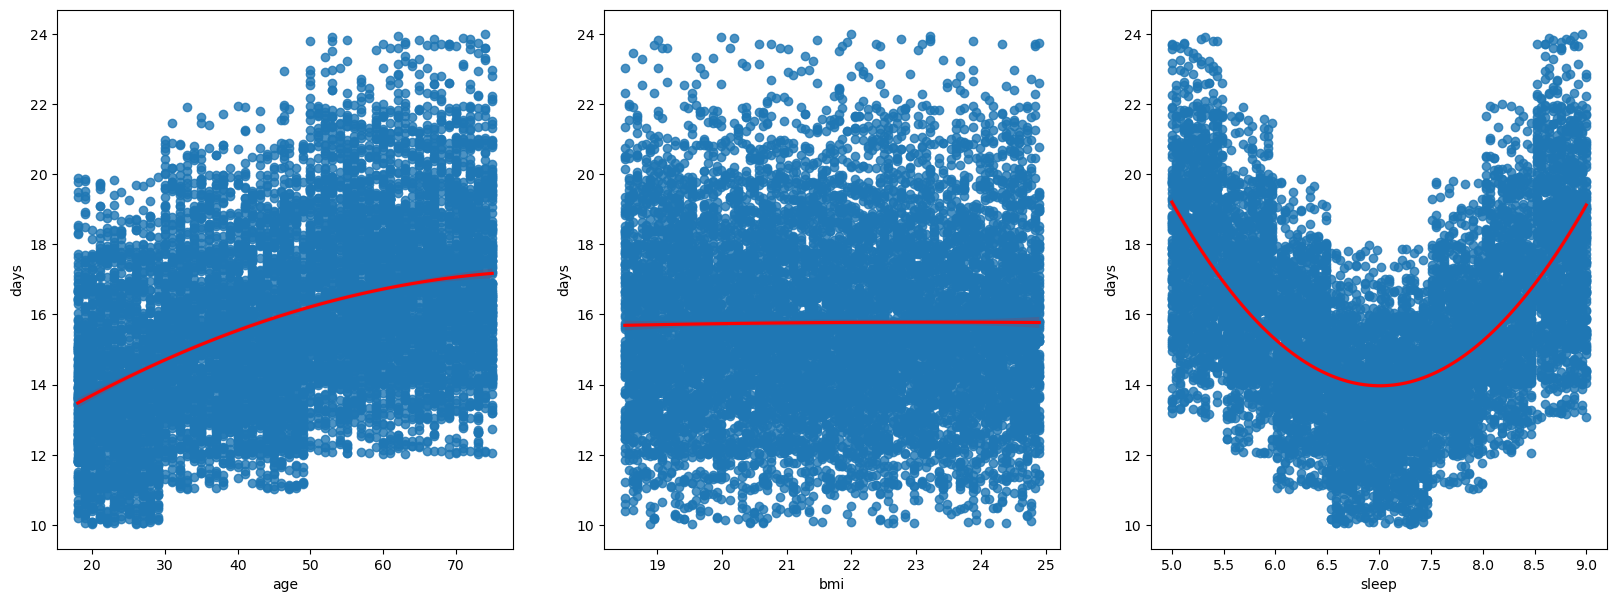

In [18]:
plt.figure(figsize=(20,7))
for i,item in enumerate(['age','bmi','sleep']):
    plt.subplot(1,3,i+1)
    sns.regplot(x = df[item],y = df['days'], data=df, order = 2,line_kws = {'color':'r'})

In [19]:
df.corr(method = 'kendall')['days'].sort_values(ascending=False)

days     1.000000
age      0.286082
bmi      0.004494
sleep   -0.004091
Name: days, dtype: float64

As, we get a rough idea that bmi and sleep are least correlated with days.

But to get sure about the values, I will determine the p-values as welll with the help of scipy library. As, the relation between the target and the independent variables are linear for two and again non-linear monotonic for the feature 'sleep', we will go for Spearman's correlation.

In [20]:
import scipy

corr_df = pd.DataFrame()
features = []
correlation = []
p_values = []

for ft in df.columns:
    if ft != 'days':
        features.append(ft)
        corr, p_val = scipy.stats.spearmanr(df['days'],df[ft])
        correlation.append(corr)
        p_values.append(p_val)
        
corr_df['Features'] = features
corr_df['Correlation'] = correlation
corr_df['p_values'] = p_values

corr_df

,Features,Correlation,p_values
0,city,-0.213627,1.946300e-102
1,gender,-0.005792,5.646727e-01
2,age,0.417405,0.000000e+00
3,bmi,0.006754,5.018608e-01
4,sleep,-0.007501,4.557926e-01


In [21]:
import scipy

corr_df = pd.DataFrame()
features = []
correlation = []
p_values = []

for ft in df.select_dtypes(exclude='object').columns:
    if ft != 'days':
        features.append(ft)
        corr, p_val = scipy.stats.spearmanr(df['days'],df[ft])
        correlation.append(corr)
        p_values.append(p_val)
        
corr_df['Features'] = features
corr_df['Correlation'] = correlation
corr_df['p_values'] = p_values

corr_df

,Features,Correlation,p_values
0,age,0.417405,0.000000
1,bmi,0.006754,0.501861
2,sleep,-0.007501,0.455793


* So, p value > 0.05 refers to the fact that with 95% confidence it can be said that there is NO CORRELATION ( ie. Null Hypothesis can't be rejected ).
* So, we can see that only 'age' has a correlation with the target variable.

But as from the graph, we saw that sleep vs target is **NOT MONOTONIC** in nature, we CAN'T rely on Spearman's correlation where the assumptions for the data to be **Linear or Non Linear but MONOTONIC**.
* `For this, we could go for **HOEFFDING'S D CORRELATION** ( assumption also cover NON MONOTONICITY ) or simply we can try to fit a polynomial regression model.

In [22]:
from sklearn.metrics import r2_score
r2 = []
for deg in [1,2]:
    model = np.polyfit(df['sleep'],df['days'],deg=deg)
    model_1d = np.poly1d(model)
    r2.append(r2_score(df['days'],model_1d(df['sleep'])))
pd.DataFrame({'Degree':[1,2],
             'R_squared':r2})

,Degree,R_squared
0,1,0.000054
1,2,0.381560


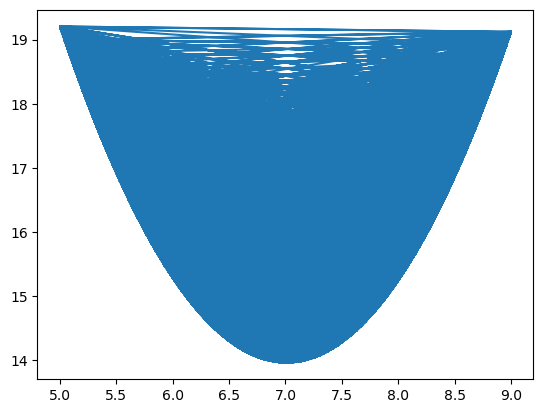

In [23]:
plt.plot(df['sleep'],model_1d(df['sleep']))

As,we can see that, r squared is not too small. So, there is some correlation so that polynomial function of degree 2 can be fitted to some extent.

### **Categorical Columns**

### Gender

In [24]:
male_days = df.loc[df['gender'] == 'Male']['days']
female_days = df.loc[df['gender'] == 'Female']['days']

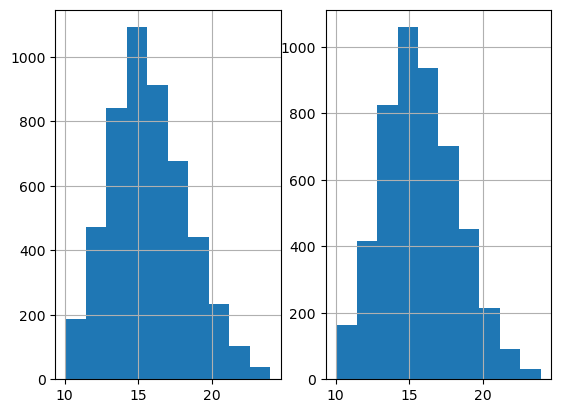

In [25]:
for i,item in enumerate([male_days, female_days]):
    plt.subplot(1,2,i+1)
    item.hist()

In [26]:
from scipy.stats import shapiro

In [27]:
from scipy.stats import shapiro
pd.DataFrame({'Distribution':['Male_days','Female_days'],
              'p_value':[shapiro(male_days)[1],shapiro(female_days)[1]]})

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Distribution,p_value
0,Male_days,2.351990e-20
1,Female_days,4.157517e-17


As, we can see that the p-values for the two distributions are very small, so they are not drawn from a normal distribution. So, we will go for Mann-Whitney test.

In [28]:
from scipy.stats import mannwhitneyu

In [29]:
### Null : Two distributions come form the same population
statistics, p_value = mannwhitneyu(male_days, female_days)
p_value

0.5646488358759658

High p_value ( greater than 0.05 ), represents that we can not reject Null Hypothesis, so the two samples come from the same population. 
* Gender DOES NOT AFFECT the target

### City

In [30]:
df['city'].value_counts()

Mumbai       5008
Bangalore    4881
Name: city, dtype: int64

In [31]:
mum_days = df.loc[df['city'] == 'Mumbai']['days']
ban_days = df.loc[df['city'] == 'Bangalore']['days']

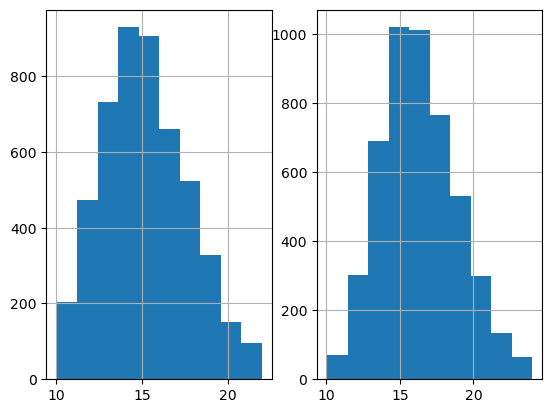

In [32]:
for i,item in enumerate([mum_days, ban_days]):
    plt.subplot(1,2,i+1)
    item.hist()

In [33]:
from scipy.stats import shapiro
pd.DataFrame({'Distribution':['mum_days','ban_days'],
              'p_value':[shapiro(mum_days)[1],shapiro(ban_days)[1]]})

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Distribution,p_value
0,mum_days,2.812488e-20
1,ban_days,7.671123e-20


Similarly, these two are also not normal.

In [34]:
### Null : Two distributions come form the same population
statistics, p_value = mannwhitneyu(mum_days, ban_days)
p_value

3.8495431863290973e-100

So, low p_value means ,two distributions came from diffferent populations.
* City DOES AFFECT the target

> ### **RESULT**

In [35]:
ft = ['city','gender','age','bmi','sleep']
rel = [1,0,1,0,1]
res = pd.DataFrame({'feature':ft,'relevance':rel})
#res.to_csv('solution.csv', index=False)

In [36]:
res

,feature,relevance
0,city,1
1,gender,0
2,age,1
3,bmi,0
4,sleep,1


In [37]:
# sol = pd.read_csv('/kaggle/working/solution.csv')
# sol